In [18]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, LabelEncoder
from sklearn.externals import joblib
import xgboost as xgb
from collections import defaultdict

# internal imports
from Autoencoder_Utils import print_features_histograms, plot_difference_displ, print_features_histograms_displ
from helpers import *

%matplotlib inline

# Original data

In [19]:
# kaon_1 = pd.read_csv('../data/VAE/NTuple_BKstee_516_517_VAE_K_in.csv')
# kaon_2 = pd.read_csv('../data/VAE/NTuple_BKstmumu_518_519_VAE_K_in.csv')

# electron_1 = pd.read_csv('../data/VAE/NTuple_BKstee_516_517_VAE_l1_in.csv')
# electron_2 = pd.read_csv('../data/VAE/NTuple_BKstee_516_517_VAE_l2_in.csv')

# muon_1 = pd.read_csv('../data/VAE/NTuple_BKstmumu_518_519_VAE_l1_in.csv')
# muon_2 = pd.read_csv('../data/VAE/NTuple_BKstmumu_518_519_VAE_l2_in.csv')

# kaon = pd.concat([kaon_1, kaon_2], axis=0)
# electron = pd.concat([electron_1, electron_2], axis=0)
# muon = pd.concat([muon_1, muon_2], axis=0)

# df = pd.concat([kaon, electron, muon], axis=0)
# df["pid"] = ["k"]*len(kaon) + ["e"]*len(electron) + ["m"]*len(muon)
# df.head()

,S5aux0,S3aux0,S2aux0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,S2aux3,S0aux4,S0aux5,S0aux6,S0aux7,S0aux8,GS3x1,GS3x0,GS0x7,pid
0,1.0,1.0,1.0,19.382790,16.0,11.772345,12.0,0.0,0.0,0.0,0.937383,3.0,3.184231,22970.26,1899.143444,2.349617,-6.289608,0.989585,k
1,1.0,1.0,1.0,12.948977,15.0,11.913938,9.0,0.0,0.0,0.0,0.844222,3.0,2.449894,8428.79,1444.099663,-7.881031,-6.549425,0.930426,k
2,1.0,1.0,1.0,17.329514,15.0,4.009862,8.0,1.0,1.0,1.0,0.877413,3.0,3.870815,6565.95,273.568119,4.563250,-8.244058,0.962666,k
3,1.0,1.0,1.0,17.420866,17.0,4.958236,6.0,0.0,0.0,0.0,0.842099,3.0,3.148228,27078.84,2320.612187,-4.410181,-8.690910,0.998305,k
4,1.0,1.0,1.0,8.845536,16.0,4.123341,10.0,1.0,1.0,1.0,0.801802,3.0,3.222980,8583.69,682.798885,2.340676,-3.726297,0.863629,k


In [32]:
# df.to_csv("./data/data_orig_combined.csv")
df = pd.read_csv("./data/data_orig_combined.csv").drop("Unnamed: 0", axis=1)
df.head()

,S5aux0,S3aux0,S2aux0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,S2aux3,S0aux4,S0aux5,S0aux6,S0aux7,S0aux8,GS3x1,GS3x0,GS0x7,pid
0,1.0,1.0,1.0,19.382790,16.0,11.772345,12.0,0.0,0.0,0.0,0.937383,3.0,3.184231,22970.26,1899.143444,2.349617,-6.289608,0.989585,k
1,1.0,1.0,1.0,12.948977,15.0,11.913938,9.0,0.0,0.0,0.0,0.844222,3.0,2.449894,8428.79,1444.099663,-7.881031,-6.549425,0.930426,k
2,1.0,1.0,1.0,17.329514,15.0,4.009862,8.0,1.0,1.0,1.0,0.877413,3.0,3.870815,6565.95,273.568119,4.563250,-8.244058,0.962666,k
3,1.0,1.0,1.0,17.420866,17.0,4.958236,6.0,0.0,0.0,0.0,0.842099,3.0,3.148228,27078.84,2320.612187,-4.410181,-8.690910,0.998305,k
4,1.0,1.0,1.0,8.845536,16.0,4.123341,10.0,1.0,1.0,1.0,0.801802,3.0,3.222980,8583.69,682.798885,2.340676,-3.726297,0.863629,k


In [33]:
print(df['pid'].value_counts())

m    430180
k    421006
e    411832
Name: pid, dtype: int64


In [34]:
vars_list = list(df)
vars_list_input, vars_list_aux, vars_list_MC = [], [], []

for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    else: 
        vars_list_input.append(v)

print("{} variables to compress".format(len(vars_list_input)))

3 variables to compress


### Split into data for xgboost (training and testing) and GAN (training and testing)

In [35]:
# train test split
xgb_size = 0.1
data_size = 0.9
idx_xgb, idx_data = train_test_split(np.arange(df.shape[0], dtype='int32'), random_state=5,
                                       stratify=df['pid'], train_size=xgb_size, test_size=data_size)

In [36]:
xgb_data = df.iloc[idx_xgb]
df = df.iloc[idx_data]
len(idx_xgb)

126301

In [37]:
xgb_data.to_csv("./data/data_for_xgb_combined.csv")

In [38]:
df.to_csv("./data/data_for_gan_combined.csv")

# Generated data

In [60]:
data_gen_k = pd.read_csv("./data/generated_pidGAN_Kramer_pidk.csv")
data_gen_m = pd.read_csv("./data/generated_pidGAN_Kramer_pidm.csv")
data_gen_e = pd.read_csv("./data/generated_pidGAN_Kramer_pide.csv")

data_gen = pd.concat([data_gen_k, data_gen_m, data_gen_e], axis=0)
data_gen.head()

/home/tgaintseva/data/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,GS0x7,GS3x0,GS3x1,S0aux0,S0aux1,S0aux2,S0aux3,S0aux4,S0aux5,S0aux6,S0aux7,S0aux8,S2aux0,S2aux1,S2aux2,S2aux3,S3aux0,S5aux0,pid
0,0.161806,-5.924373,1.229928,NaN,NaN,NaN,NaN,NaN,NaN,0.281227,-0.012882,NaN,0.0,NaN,NaN,NaN,0.0,0.0,k
1,0.803198,-5.800195,-5.304009,NaN,NaN,NaN,NaN,NaN,NaN,-0.003120,0.070954,NaN,0.0,NaN,NaN,NaN,0.0,0.0,k
2,0.996368,-6.458336,-3.225239,NaN,NaN,NaN,NaN,NaN,NaN,0.481110,0.025829,NaN,0.0,NaN,NaN,NaN,0.0,0.0,k
3,0.999435,-6.093815,-0.854372,NaN,NaN,NaN,NaN,NaN,NaN,-0.312733,-0.000332,NaN,0.0,NaN,NaN,NaN,0.0,0.0,k
4,0.614984,-3.684101,-6.764263,NaN,NaN,NaN,NaN,NaN,NaN,0.531211,0.019074,NaN,0.0,NaN,NaN,NaN,0.0,-1.0,k


In [61]:
gen_X_test = data_gen[['GS3x1', 'GS3x0', 'GS0x7']]
gen_y_test = ["k"]*len(data_gen_k) + ["m"]*len(data_gen_m) + ["e"]*len(data_gen_e)
gen_y_test = le.transform(gen_y_test)

In [62]:
np.unique(gen_y_test )

array([0, 1, 2])

# XGBoost

In [41]:
xgb_input = xgb_data[vars_list_input].values
xgb_aux   = xgb_data[vars_list_aux].values
xgb_MC    = xgb_data[vars_list_MC].values

le = LabelEncoder()
y = le.fit_transform(xgb_MC[:, 0])
le.classes_

array(['e', 'k', 'm'], dtype=object)

In [42]:
vars_list_input

['GS3x1', 'GS3x0', 'GS0x7']

In [43]:
xgb_input.shape, y.shape, xgb_MC.shape, xgb_data.shape

((126301, 3), (126301,), (126301, 1), (126301, 19))

### split xgb data into train and test

In [44]:
test_size = 0.3

idx_train_clf, idx_test_clf = train_test_split(np.arange(xgb_input.shape[0]), stratify=y, 
                                               random_state=42, test_size=test_size)
X_train, X_test = xgb_input[idx_train_clf], xgb_input[idx_test_clf]
y_train, y_test = y[idx_train_clf], y[idx_test_clf]

X_train_aux, X_test_aux = xgb_aux[idx_train_clf], xgb_aux[idx_test_clf]

In [49]:
clf_name = "XGBoost"
clf = xgb.XGBClassifier(nthread=-1, seed=111)
# clf.fit(X_train, y_train)
# joblib.dump(clf, os.path.join('./xgboost_models', clf_name) + ".pkl")
clf = joblib.load(os.path.join('./xgboost_models', clf_name) + ".pkl")

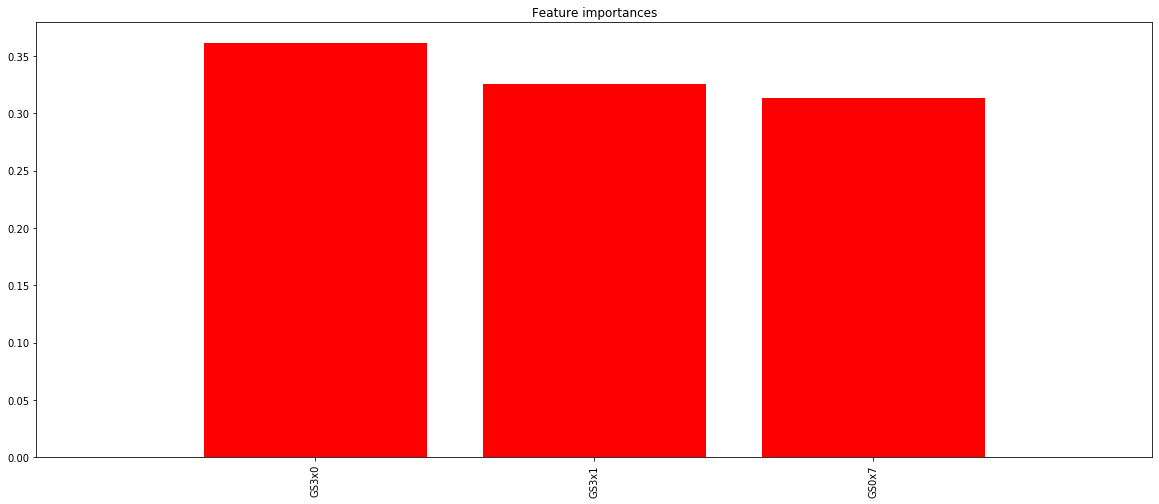

In [37]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

columns_num = 3

plt.figure(figsize=(20, 8))
plt.title("Feature importances")
plt.bar(range(columns_num), importances[indices],
       color="r",  align="center")
plt.xticks(range(columns_num), xgb_data[vars_list_input].columns[indices])
plt.xlim([-1, columns_num])
plt.xticks(rotation=90)
plt.show()

In [26]:
pd.DataFrame(np.concatenate([X_train, y_train.reshape(y_train.shape[0], 1)], axis=1), columns=vars_list_input+["pid"]).to_csv("./data/orig_train_old.csv")

In [50]:
path_to_metrics = './metrics/'
metrics_dir_name = "ae_old"

metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

In [51]:
np.unique(y_test)

array([0, 1, 2])

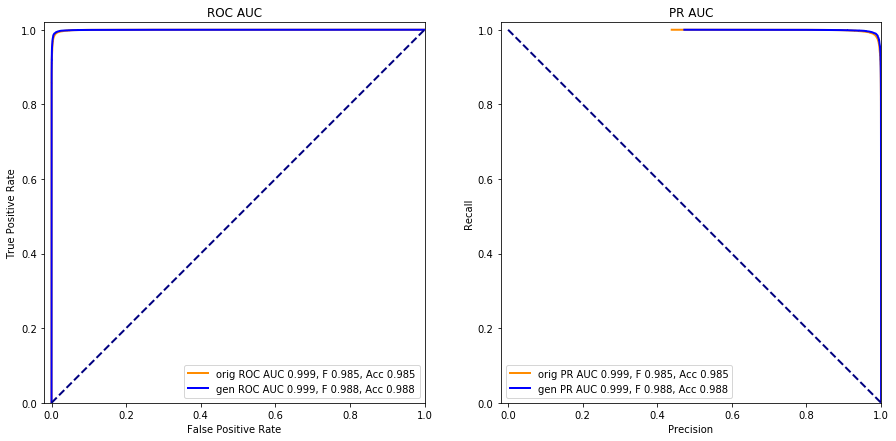

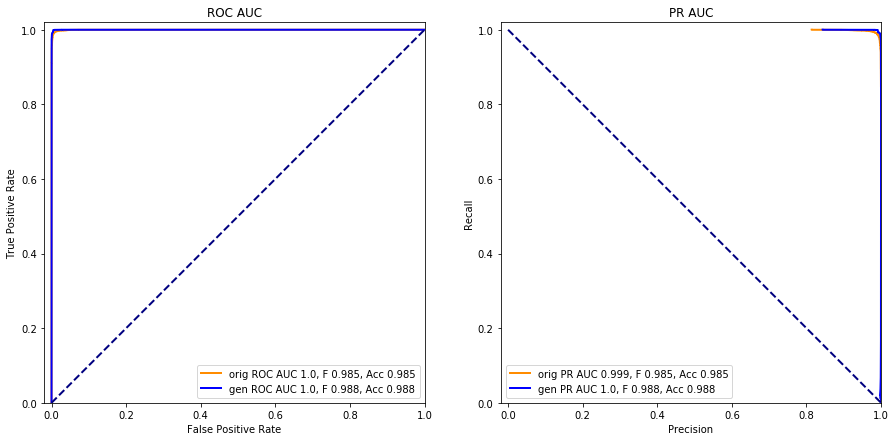

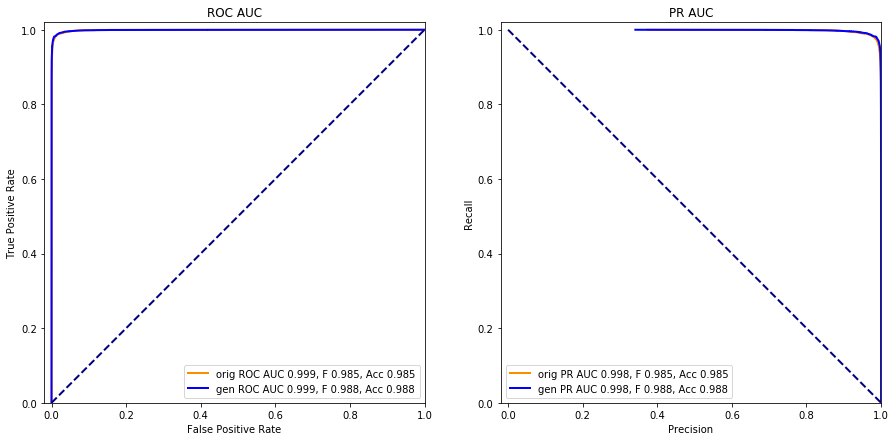

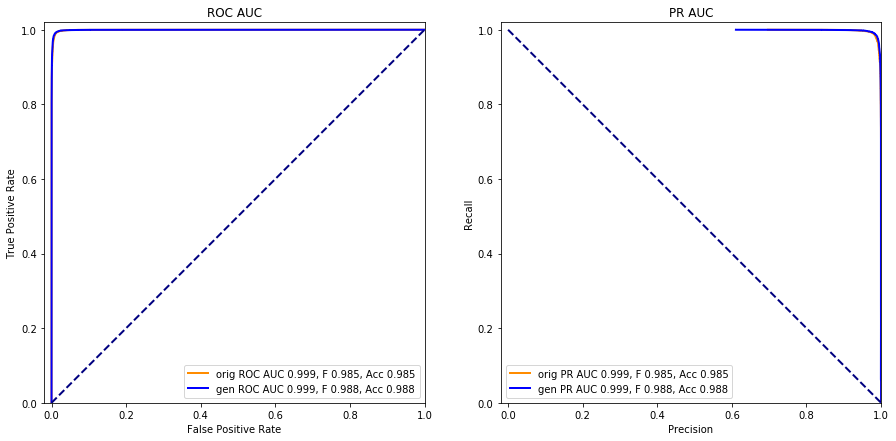

100%|██████████| 2/2 [00:07<00:00,  3.95s/it]


In [63]:
import os
for encoding_dim in tqdm(["orig", "gen"]):
    if encoding_dim == "orig":
        y_proba = clf.predict_proba(X_test)
        y_real = y_test
    elif encoding_dim == "gen":
        y_proba = clf.predict_proba(gen_X_test.values)
        y_real = gen_y_test
    y_pred = np.argmax(y_proba, axis=1)
    y_bin = label_binarize(y_real, classes=np.unique(y_real))
    
    # Compute ROC/PR curve and ROC/PR area for each class
    for pid_label in np.unique(y_real):
        idx = np.where(y_real == pid_label)[0]
        cur_y = np.where(y_real == pid_label, np.ones_like(y_real), np.zeros_like(y_real))
        cur_y_proba = y_proba[:, pid_label]
        
        pid_label = str(pid_label)
        metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], _ = \
            roc_curve(cur_y, cur_y_proba)
        metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], _ = \
            precision_recall_curve(cur_y, cur_y_proba)
        
        metrics_dict['roc_auc'][encoding_dim][pid_label] = auc(
            metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label])
        metrics_dict['pr_auc'][encoding_dim][pid_label] = average_precision_score(cur_y.ravel(), cur_y_proba.ravel())
        
    metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
        roc_curve(y_bin.ravel(), y_proba.ravel())
    metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
        precision_recall_curve(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
    metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['f_measure'][encoding_dim] = f1_score(y_real, y_pred, average='micro')
    metrics_dict['acc'][encoding_dim] = accuracy_score(y_real, y_pred)
    
    # Save
    dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)
    
    # Plot
    display.clear_output(wait=True)
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='0', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='1', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
    plot_metrics(metrics_dict, pid_label='2', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
#     plot_metrics(metrics_dict, pid_label='3', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
#     plot_metrics(metrics_dict, pid_label='4', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
#     plot_metrics(metrics_dict, pid_label='5', xlim=(-0.02, 1), ylim=(0, 1.02), save_path=os.path.join(path_to_metrics, metrics_dir_name))
#     fig.savefig('./plots/{}_dim_{}.png'.format(MODEL_NAME, encoding_dim))